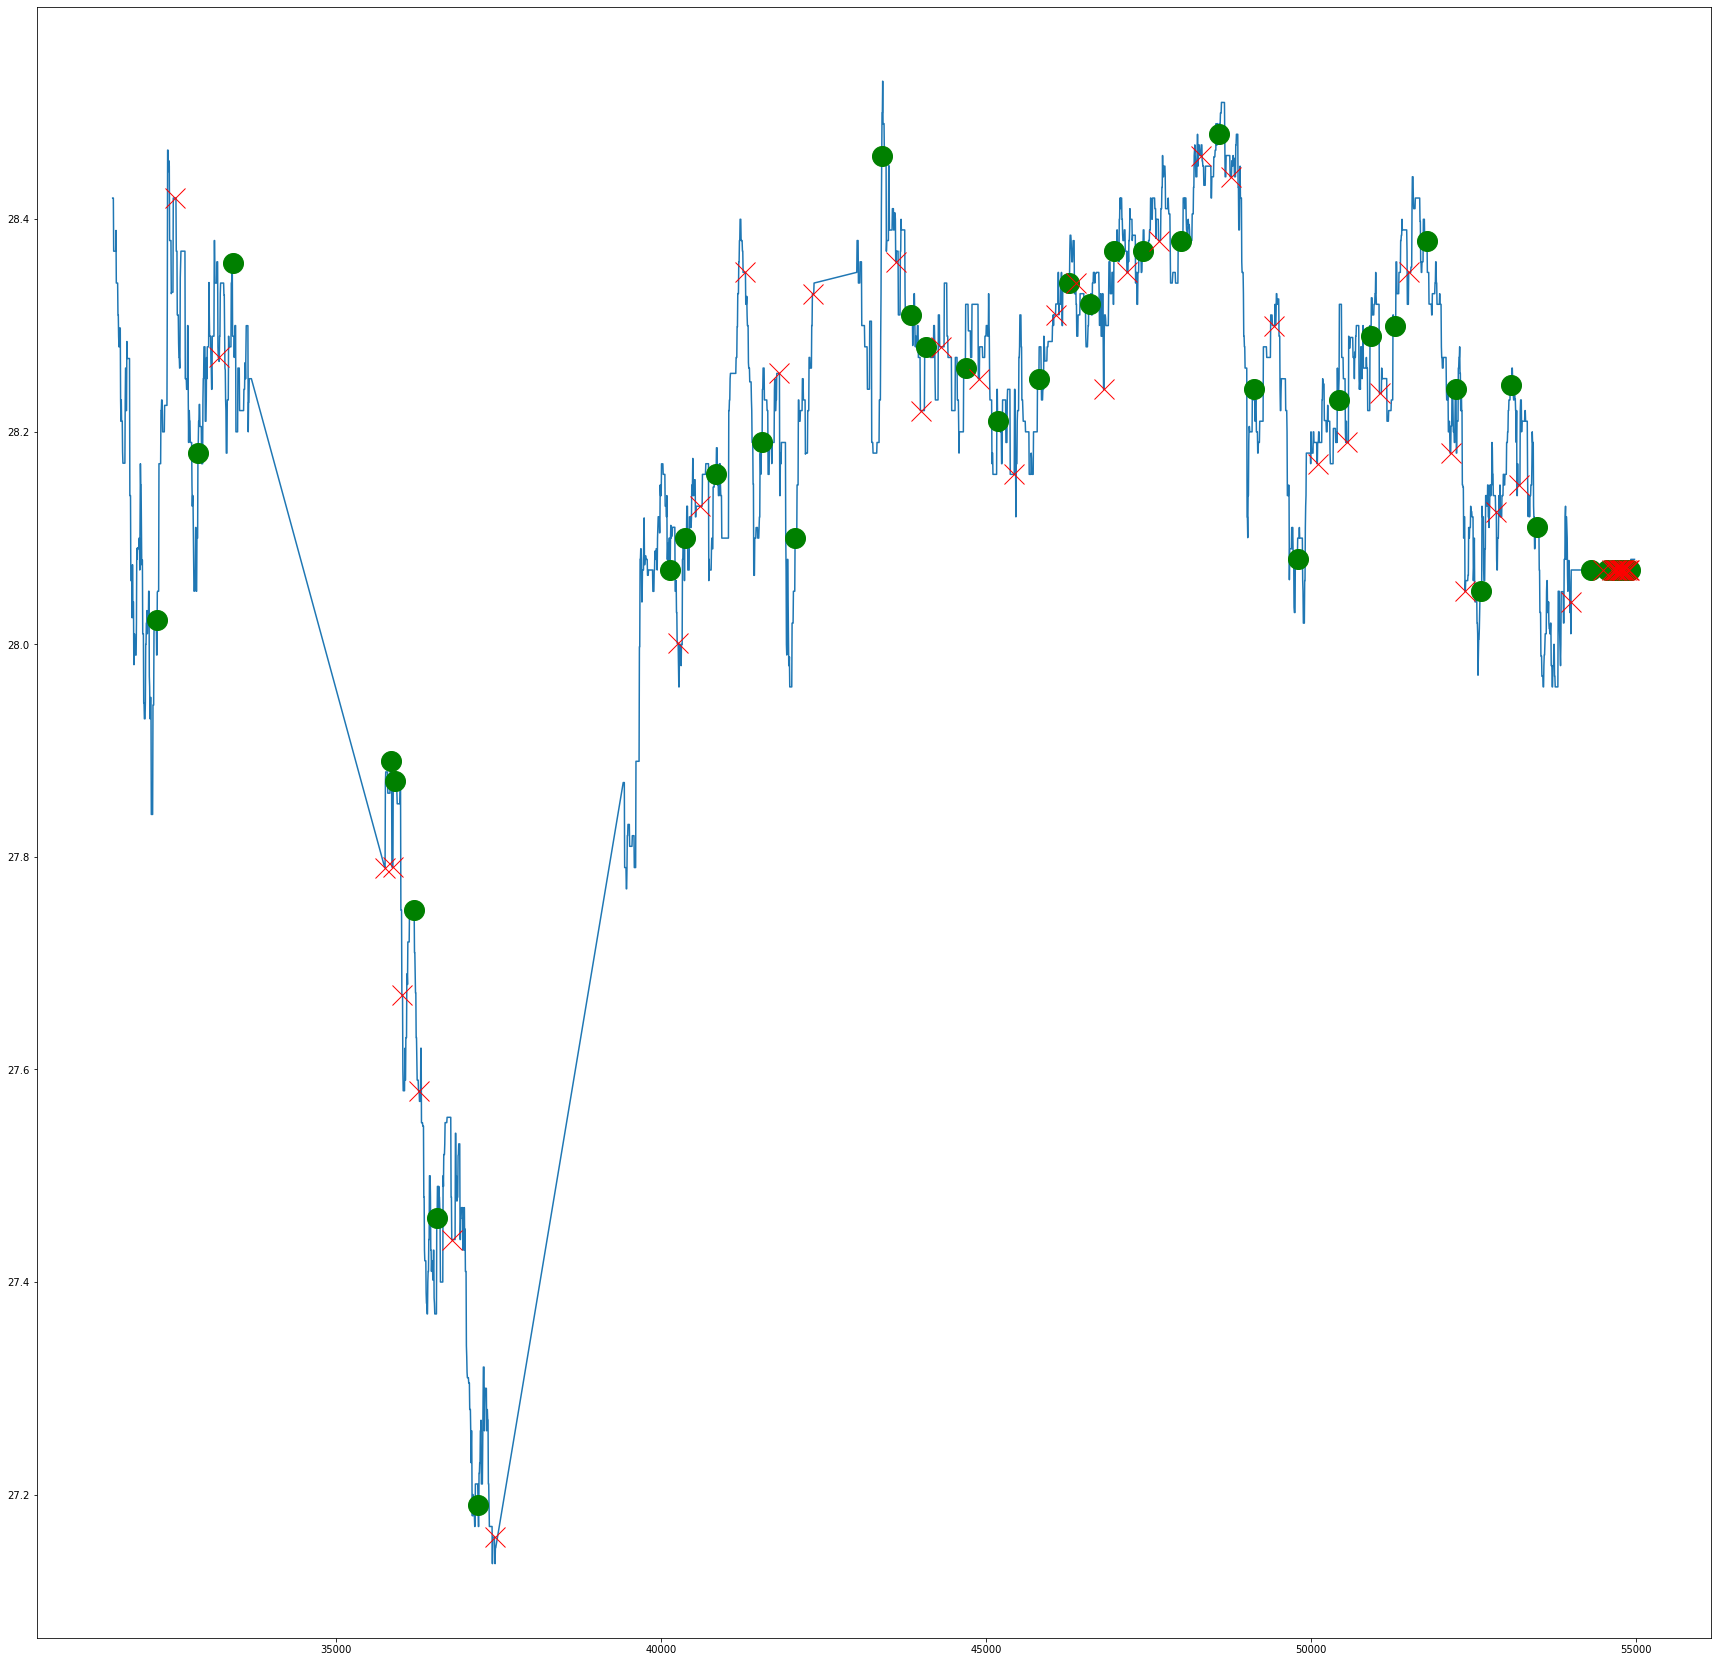

In [190]:
import matplotlib.pyplot as plt
import pandas as pd

def convert_timestamp(x):
    d = datetime.date.today()
    d_today = datetime.datetime(d.year, d.month, d.day)
    return (x - d_today).total_seconds()

symbol = 'URTY'
date = datetime.date.today()
data_dir = 'data/'
filename_data = data_dir + '{}_{}.csv'.format(date, symbol)
df_data = pd.read_csv(filename_data)

filename_transaction = data_dir + 'trans_{}_{}.csv'.format(symbol, date)
df_transaction = pd.read_csv(filename_transaction)


x = df_data.timestamp_sec
y = df_data.price

df_transaction['timestamp'] = df_transaction['timestamp'].astype(np.datetime64)
df_transaction['timestamp_sec'] = df_transaction['timestamp'].apply(convert_timestamp)

x_buy = df_transaction[df_transaction.action == 'BUY'].timestamp_sec
y_buy = df_transaction[df_transaction.action == 'BUY'].price
x_sell = df_transaction[df_transaction.action == 'SELL'].timestamp_sec
y_sell = df_transaction[df_transaction.action == 'SELL'].price

# x_buy = df_data[df_data['']]
plt.figure(figsize=(30, 30))
# # buy green o's
# # puts red x's
plt.plot(x, y, '-', x_buy, y_buy, 'go', x_sell, y_sell, 'rx', markersize=20)
plt.show()
# print('window:{}'.format(window))
# t.results()

In [5]:
import logging

logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger()

class trader:
    def __init__(self, ammo:float, amt:float=1):
        self.ammo = ammo
        self.amt_per_trans = amt
        self.transactions = 0
        self.num_buy = 0
        self.num_sell = 0
        self.stocks = 0
        self.last_price = 0
        
    def update_last_price(self, price:float):
        self.last_price = price
        
    def buy(self, price:float):
        self.last_price = price
        if self.ammo - price * self.amt_per_trans < 0:
            logger.debug('unable to buy')
        else:
            self.ammo -= price * self.amt_per_trans
            self.num_buy += 1
            self.stocks += self.amt_per_trans

            logger.debug('buy {} at {}'.format(self.amt_per_trans, price))

    def sell(self, price:float):
        self.last_price = price

        if self.stocks - self.amt_per_trans < 0:
            
            logger.debug('unable to sell')
        else:
            self.num_sell += 1
            self.ammo += price * self.amt_per_trans
            self.stocks -= self.amt_per_trans
            logger.debug('sell {} at {}'.format(self.amt_per_trans, price))

    def results(self):
        print('total transactions today: {}'.format(self.num_buy + self.num_sell))
        print('total bullet left: {}'.format(self.ammo))
        print('total stocks left: {}'.format(self.stocks))
        print('stock asset value: {}'.format(self.stocks * self.last_price))
        print('total asset value: {}'.format(self.stocks * self.last_price + self.ammo))

In [152]:
import time
import logging

logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger()

def analysis(df, rh:Robinhood, symbol:str, start_amount:float, window=20*5):
    if len(df) != window:
        logger.debug('not enough datapoints')
        while len(df) != window:
            df = df.append(df.from_dict(get_quote(rh, symbol)).reset_index())
#             time.sleep(1)
    logger.debug('enought datapoints: starting analyzing... {}'.format(len(df)))

    t = trader(start_amount)
    # possible inflection coordinates
    x_inf = list()
    y_inf = list()
    x_inf_put = list()
    y_inf_put = list()
    s = Symbol('x')

    prev = None

    try:
        while True:
            df = df.append(df.from_dict(get_quote(rh, symbol)).reset_index())
            time.sleep(1)
            df_temp = df.iloc[-1*window:]

            x = df_temp.timestamp_sec.astype(float)
            y = df_temp.price.astype(float)

            z = np.polyfit(x, y, 3)
            eq = eq_builder(z, 'x')
            sympy_exp = parse_expr(eq)

            # double derivative
            d = sympy_exp.diff(s).diff(s)
            result = solve(d,s)

            if len(result) == 1:
                l = d.evalf(subs={s: result[0]-0.5})
                r = d.evalf(subs={s: result[0]+0.5})
                if prev:
                    # look for concavity changes
                    if (prev >= 0 and r < 0) or (r >= 0 and prev < 0):
                        # only if inflection point exists within time window
                        if result[0] >= list(x_new)[0] and result[0] <= list(x_new)[-1]:
                            if prev < 0 and r >= 0:
                                t.buy(list(y)[-1])
                                x_inf += [list(x)[-1]]
                                y_inf += [list(y)[-1]]
                            else:
                                t.sell(list(y_new)[-1])
                                x_inf_put += [list(x)[-1]]
                                y_inf_put += [list(y)[-1]]

                            t.update_last_price(list(y)[-1])
                            t.results()

                            f = np.poly1d(z)
                            y_fit = f(x)
                            inflection_point = sympy_exp.evalf(subs={s: result[0]})
                            plt.plot(x, y, '-', x, y_fit, 'b-', result[0], inflection_point, 'rx', \
                                     list(x)[-1], list(y)[-1], 'go')
                            plt.show()
                            prev = r
                else:
                    prev = r
            else:
                print('unsolvable?', result)
        
    except KeyboardInterrupt:
        df.to_csv('data/{}_{}'.format(datetime.date.today(), symbol))

        print(x_inf)
        print(y_inf)

In [153]:
df = pd.DataFrame()
%load_ext autoreload
%autoreload 2

from pyrh import Robinhood, dump_session, load_session
from pyrh.exceptions import InvalidCacheFile
import getpass

# Log in to app (will prompt for two-factor)
try:
    rh = load_session()
except InvalidCacheFile:
    rh = Robinhood(username="sangchoi93@gmail.com", password=getpass.getpass())
    rh.login()
    dump_session(rh) # so you don't have to do mfa again


    
analysis(df, rh, 'AAPL', 2000)

DEBUG:root:not enough datapoints
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.robinhood.com:443


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


DEBUG:urllib3.connectionpool:https://api.robinhood.com:443 "GET /quotes/AAPL/ HTTP/1.1" 200 None
DEBUG:urllib3.connectionpool:https://api.robinhood.com:443 "GET /quotes/AAPL/ HTTP/1.1" 200 None
DEBUG:urllib3.connectionpool:https://api.robinhood.com:443 "GET /quotes/AAPL/ HTTP/1.1" 200 None
DEBUG:urllib3.connectionpool:https://api.robinhood.com:443 "GET /quotes/AAPL/ HTTP/1.1" 200 None
DEBUG:urllib3.connectionpool:https://api.robinhood.com:443 "GET /quotes/AAPL/ HTTP/1.1" 200 None
DEBUG:urllib3.connectionpool:https://api.robinhood.com:443 "GET /quotes/AAPL/ HTTP/1.1" 200 None
DEBUG:urllib3.connectionpool:https://api.robinhood.com:443 "GET /quotes/AAPL/ HTTP/1.1" 200 None
DEBUG:urllib3.connectionpool:https://api.robinhood.com:443 "GET /quotes/AAPL/ HTTP/1.1" 200 None
DEBUG:urllib3.connectionpool:https://api.robinhood.com:443 "GET /quotes/AAPL/ HTTP/1.1" 200 None
DEBUG:urllib3.connectionpool:https://api.robinhood.com:443 "GET /quotes/AAPL/ HTTP/1.1" 200 None
DEBUG:urllib3.connectionpool:h

DEBUG:urllib3.connectionpool:https://api.robinhood.com:443 "GET /quotes/AAPL/ HTTP/1.1" 200 None
DEBUG:urllib3.connectionpool:https://api.robinhood.com:443 "GET /quotes/AAPL/ HTTP/1.1" 200 None
DEBUG:urllib3.connectionpool:https://api.robinhood.com:443 "GET /quotes/AAPL/ HTTP/1.1" 200 None
DEBUG:urllib3.connectionpool:https://api.robinhood.com:443 "GET /quotes/AAPL/ HTTP/1.1" 200 None
DEBUG:urllib3.connectionpool:https://api.robinhood.com:443 "GET /quotes/AAPL/ HTTP/1.1" 200 None
DEBUG:urllib3.connectionpool:https://api.robinhood.com:443 "GET /quotes/AAPL/ HTTP/1.1" 200 None
DEBUG:urllib3.connectionpool:https://api.robinhood.com:443 "GET /quotes/AAPL/ HTTP/1.1" 200 None
DEBUG:urllib3.connectionpool:https://api.robinhood.com:443 "GET /quotes/AAPL/ HTTP/1.1" 200 None
DEBUG:urllib3.connectionpool:https://api.robinhood.com:443 "GET /quotes/AAPL/ HTTP/1.1" 200 None
DEBUG:urllib3.connectionpool:https://api.robinhood.com:443 "GET /quotes/AAPL/ HTTP/1.1" 200 None
DEBUG:urllib3.connectionpool:h

[]
[]


In [45]:
%load_ext autoreload
%autoreload 2

from pyrh import Robinhood, dump_session, load_session
from pyrh.exceptions import InvalidCacheFile
import getpass

# Log in to app (will prompt for two-factor)
try:
    rh = load_session()
except InvalidCacheFile:
    rh = Robinhood(username="sangchoi93@gmail.com", password=getpass.getpass())
    rh.login()
    dump_session(rh) # so you don't have to do mfa again



In [96]:
def get_quote(rh, ind:str):
    time_now = datetime.datetime.now()
    d = datetime.date.today()
    d_today = datetime.datetime(d.year, d.month, d.day)
    quote = rh.quote_data('AAPL')
    d = {
        'timestamp':[time_now.isoformat()],
        'timestamp_sec':[(time_now - d_today).total_seconds()],
        'price':[quote['last_trade_price']]
    }
    
    return d
    

In [56]:
now = datetime.datetime.now()
get_quote(rh, 'AAPL')
print(datetime.datetime.now() - now)


DEBUG:urllib3.connectionpool:https://api.robinhood.com:443 "GET /quotes/AAPL/ HTTP/1.1" 200 None


0:00:00.091605


In [99]:
get_quote(rh, 'srt')

DEBUG:urllib3.connectionpool:https://api.robinhood.com:443 "GET /quotes/AAPL/ HTTP/1.1" 200 None


{'timestamp': ['2020-05-18T23:08:15.245702'],
 'timestamp_sec': [83295.245702],
 'price': ['314.960000']}

In [158]:
quote = rh.quote_data('SRTY')
print(quote)

DEBUG:urllib3.connectionpool:https://api.robinhood.com:443 "GET /quotes/SRTY/ HTTP/1.1" 200 None


{'ask_price': '15.500000', 'ask_size': 100, 'bid_price': '15.470000', 'bid_size': 1100, 'last_trade_price': '15.240000', 'last_extended_hours_trade_price': '15.440000', 'previous_close': '18.610000', 'adjusted_previous_close': '18.610000', 'previous_close_date': '2020-05-15', 'symbol': 'SRTY', 'trading_halted': False, 'has_traded': True, 'last_trade_price_source': 'consolidated', 'updated_at': '2020-05-19T13:11:54Z', 'instrument': 'https://api.robinhood.com/instruments/0bb9caf8-e8cb-49c3-9544-8235650dc5f5/'}


In [36]:
d = datetime.date.today()
d_today = datetime.datetime(d.year, d.month, d.day)


datetime.datetime(2020, 5, 18, 0, 0)

In [128]:
d = get_quote(rh, 'AAPL')
df = df.append(df.from_dict(get_quote(rh, 'AAPL')).reset_index())

DEBUG:urllib3.connectionpool:https://api.robinhood.com:443 "GET /quotes/AAPL/ HTTP/1.1" 200 None
DEBUG:urllib3.connectionpool:https://api.robinhood.com:443 "GET /quotes/AAPL/ HTTP/1.1" 200 None


In [136]:
df = pd.read_csv('/src/data/')

2020-05-18


In [187]:
rh.quote_data('AAPL')

DEBUG:urllib3.connectionpool:Resetting dropped connection: api.robinhood.com
DEBUG:urllib3.connectionpool:https://api.robinhood.com:443 "GET /quotes/AAPL/ HTTP/1.1" 200 None


{'ask_price': '350.000000',
 'ask_size': 1100,
 'bid_price': '318.760000',
 'bid_size': 10,
 'last_trade_price': '319.230000',
 'last_extended_hours_trade_price': '319.200000',
 'previous_close': '313.140000',
 'adjusted_previous_close': '313.140000',
 'previous_close_date': '2020-05-19',
 'symbol': 'AAPL',
 'trading_halted': False,
 'has_traded': True,
 'last_trade_price_source': 'consolidated',
 'updated_at': '2020-05-21T00:00:00Z',
 'instrument': 'https://api.robinhood.com/instruments/450dfc6d-5510-4d40-abfb-f633b7d9be3e/'}

In [186]:
ins

{'ask_price': '350.000000',
 'ask_size': 1100,
 'bid_price': '318.760000',
 'bid_size': 10,
 'last_trade_price': '319.230000',
 'last_extended_hours_trade_price': '319.200000',
 'previous_close': '313.140000',
 'adjusted_previous_close': '313.140000',
 'previous_close_date': '2020-05-19',
 'symbol': 'AAPL',
 'trading_halted': False,
 'has_traded': True,
 'last_trade_price_source': 'consolidated',
 'updated_at': '2020-05-21T00:00:00Z',
 'instrument': 'https://api.robinhood.com/instruments/450dfc6d-5510-4d40-abfb-f633b7d9be3e/'}